In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))
display(HTML(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """))

<div class="alert alert-block alert-danger">
These notebooks are better visualized using codefolding from Jupyter
    <a href=\"https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/\">extensions</a>.
</div>

# SIRD parameter learning using nmAPG with Tikhonov regularisation

$\newcommand{\R}{\,\mathbb{R}} \newcommand{\dif}{\mathrm{d}} \newcommand{\diag}{\mathrm{diag}} \newcommand{\vec}{\mathrm{vec}}  \newcommand{\circulant}{\mathrm{circ}} \newcommand{\mat}{\mathrm{mat}} \newcommand{\ifft}{\hat{\mathcal{F}}} \newcommand{\fft}{\mathcal{F}}$
<div class="alert alert-block alert-success">
This notebook aims to solve the minimisation problem
\begin{align}
    \min_{\alpha \in [L^2(0,1)]^3} f(\alpha) = \frac{1}{2} \| \rho - \widehat{\rho} \|_2^2 + \frac{\theta}{2} \|\alpha\|_2^2 + \frac{\vartheta}{2} \| \rho(T) - \widehat{\rho}(T) \|^2_{\R^3},
\end{align}
where $\rho = (\begin{smallmatrix} \sigma & I & R & D \end{smallmatrix})$ comes from the solution of a change of variables applied to the Susceptibles, Infected, Recovered, and Deceased (SIRD) model, and $\widehat{\rho}$ is a target and known state. The regularisation parameters $\theta$ and $\vartheta$ are non negative. We will study the effect of this parameter on the choice of the control pair $\alpha$.
    
For each pair of parameters $\alpha(t) = (\beta(t), \gamma(t),m(t)) \in [0,1]^3$ corresponding to the transmission and the recovery rates, the four variables $S(t)$, $I(t)$, $R(t)$, and $D(t)$ are governed by the following differential equations
    
\begin{align}
    \tag{$\star$}
\begin{aligned}
    \frac{\dif \sigma}{\dif t} &= a_1\beta (\mathsf{n} - \sigma) I,
    \\
    \frac{\dif I}{\dif t} &= a_1\beta (\mathsf{n} - \sigma) I - (a_2\gamma + a_3 m) I,
    \\
    \frac{\dif R}{\dif t} &= a_2\gamma I,
    \\
    \frac{\dif D}{\dif t} &= a_3\gamma I.
\end{aligned}
\end{align}
We note that $ \mathsf{n} $ is the total population at the start of the study.
    
</div>

In [1]:
# Packages
import time
import numpy  as np
import pandas as pd
import gurobipy as GRB
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from scipy.integrate import solve_ivp

In [3]:
# Single function imports
from numpy           import array, asarray, sin, cos, zeros, linspace, argmin, meshgrid, unravel_index
from numpy           import concatenate, minimum, maximum, exp, ones, eye, empty, append, diagflat, tril, triu
from numpy.random    import default_rng as rng
from scipy.linalg    import norm, eigvals, inv
from scipy.integrate import simpson, trapezoid
from scipy.optimize  import minimize, Bounds
from scipy.interpolate import CubicHermiteSpline, interp1d
from scipy.sparse.linalg import LinearOperator
from scipy.sparse    import eye as speye
from scipy.sparse    import bmat
from numpy.polynomial.chebyshev import chebpts1
from matplotlib import colormaps

# Model scaling

We scale the baseline original ODE system for the SIRD model. Assuming $\overline{\rho}(\tau)$ satisfies the original SIRD ODE system above with parameters $\overline\alpha = (\overline\beta, \overline\gamma, \overline{m})$ and initial condition $\overline{\rho}_0$, then $(\star)$ above is related with $\overline{\rho}$ via the relationships

* Population scaling: $\overline{\rho} = s_1 \rho$, where $ \rho_{\mathsf{S}} = \mathsf{n} - \sigma $,

* Time scaling: $\tau = s_2 t$,

* Parameter scalings: $\overline{\alpha} = \left( \frac{a_1}{s_1 s_2} \beta, \frac{a_2}{s_2} \gamma, \frac{a_3}{s_2} m \right)$.

# Data loading

We load data used in [[1]](https://doi.org/10.1016/j.rico.2023.100346). Locally, we have stored data of susceptible, infected, recovered, and deceased compartments from June 1 – July 20, 2021. When constructing the dataset, the total population size $\mathsf{n}$ was set to 164\,689\,383 given by an estimate from [[3]](https://www.worldometers.info/world-population/bangladesh-population/). We will set $\mathsf{n}$ to be equal to the total number of people at the initial time.

In [4]:
SIRD_data = pd.read_pickle('BD_2021_Jun_Jul.pkl').values.astype('float64')

In [5]:
print('𝗇̄: {0:.0f}'.format(np.unique(SIRD_data.sum(1)).item()))

𝗇̄: 164689383


In [6]:
σ_data = SIRD_data.sum(1) - SIRD_data[:,0]

In [7]:
ΣIRD_data = np.c_[σ_data, SIRD_data[:,1:]]      # Determine σ and remove S compartment

In [8]:
int(ΣIRD_data.max()), int(SIRD_data.max())      # There is quite a difference in order of magnitude

(22887, 164686226)

The data considers reports spanning 60 days. 

In [9]:
T = np.float64(ΣIRD_data.shape[0])

**Scales**

We will group the observations by week and label the initial week by $0$; i.e., $s = 7$ and $T = 50/7 \approx 7$. We will scale people by the maximum expected value of the residual susceptibles $\sigma$:

In [10]:
time_scale = 7.0                 # s_2
ppl_scales = ΣIRD_data.max();    # s_1

In [11]:
T /= time_scale                        # Scale time
ΣIRD_data /= ppl_scales                # Scale population: (helps in computation time)

In [12]:
# Make an interval span
Tᵒᵇˢ  = linspace(0,T,SIRD_data.shape[0])

We build a piecewise interpolator for computing any integral terms:

In [13]:
Tₑ = 0.5*(chebpts1(152-2+1)+1) * T     # Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],Tₑ,[T]])         # Add endpoints
# Add observed points
Tₑ = np.unique(np.sort(concatenate([Tₑ,Tᵒᵇˢ])))

In [14]:
Tₑ.size    # odd number of collocation points for Simpson

201

In [15]:
ρ̄ = interp1d(Tᵒᵇˢ,ΣIRD_data[:,].T, axis=-1, kind = 'quadratic')
ρ̂ = ρ̄(Tₑ)

In [16]:
ρ̄(0).sum()

0.3132782802464281

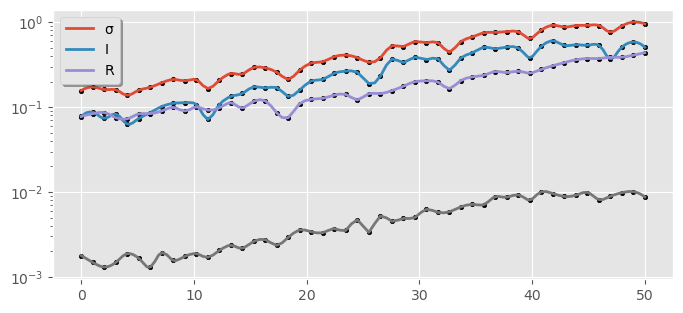

In [17]:
# Plot data
plt.figure(figsize=(8,3.5))

plt.plot(Tₑ*time_scale, ρ̂.T, '-', linewidth=2)
for i in range(4):
    plt.scatter(Tᵒᵇˢ*time_scale, ΣIRD_data[:,i], s=10, c='black')
plt.yscale('log')

plt.legend(['σ', 'I', 'R'], shadow=True)
plt.show()

Compare numerical ranges for different scales:

In [18]:
# Original data:
lows = np.min(SIRD_data, 0);    ups  = np.max(SIRD_data, 0);    strs = ['S̄', 'Ī', 'R̄', 'D̄']
for i in range(4):
    print('{0:9.0f} ≤ {1:s} ≤ {2:.0f}'.format(lows[i], strs[i], ups[i]))

164666496 ≤ S̄ ≤ 164686226
     1447 ≤ Ī ≤ 13768
     1667 ≤ R̄ ≤ 9997
       30 ≤ D̄ ≤ 231


In [19]:
# Scaling by total population is not that good:
lows = np.min(SIRD_data, 0)/SIRD_data[0].sum();    ups  = np.max(SIRD_data, 0)/SIRD_data[0].sum();    strs = ['S̄', 'Ī', 'R̄', 'D̄']
for i in range(4):
    print('{0:.4e} ≤ {1:s} ≤ {2:.4e}'.format(lows[i], strs[i], ups[i]))

9.9986e-01 ≤ S̄ ≤ 9.9998e-01
8.7862e-06 ≤ Ī ≤ 8.3600e-05
1.0122e-05 ≤ R̄ ≤ 6.0702e-05
1.8216e-07 ≤ D̄ ≤ 1.4026e-06


In [20]:
# σIR data is well behaved:
lows = np.min(ΣIRD_data, 0);    ups  = np.max(ΣIRD_data, 0);    strs = ['σ̄', 'Ī', 'R̄', 'D̄']
for i in range(4):
    print('{0:.3f} ≤ {1:s} ≤ {2:.3f}'.format(lows[i], strs[i], ups[i]))

0.138 ≤ σ̄ ≤ 1.000
0.063 ≤ Ī ≤ 0.602
0.073 ≤ R̄ ≤ 0.437
0.001 ≤ D̄ ≤ 0.010


We see that the $\sigma \mathsf{IR}$ model is better scaled by compartment and explicitly shows the evolution of $\sigma$. In contrast, the susceptible compartment in the original model might give the impression that it is a constant.

### Prior information

In the original paper, the authors obtained the following constant–in–time estimates:

In [21]:
print('β̂: {0:.15f}, γ̂: {1}, m̂: {2}'.format(0.0706 / 164689383, 0.0257, 0.0011))

β̂: 0.000000000428686, γ̂: 0.0257, m̂: 0.0011


Using the current scales, we obtain the better behaved values:

In [22]:
print('β̂: {0:.8f}, γ̂: {1}, m̂: {2}'.format(ppl_scales * time_scale * 0.0706 / 164689383, time_scale * 0.0257, time_scale * 0.0011))

β̂: 0.00006868, γ̂: 0.1799, m̂: 0.0077


We notice that $\beta$ and $\gamma$ are still very small. So we can use $a_1 = 10^{-4}$, $a_2 = 1$, and $a_3 = 10^{-2}$ to obtain:

In [23]:
aᵦ = 1e-4;    aᵧ = 1.0;    aₘ = 1e-2
print('β̂: {0:.8f}, γ̂: {1}, m̂: {2}'.format(ppl_scales * time_scale * 0.0706 / (164689383 * aᵦ), time_scale * 0.0257/aᵧ, time_scale * 0.0011/aₘ))

β̂: 0.68679323, γ̂: 0.1799, m̂: 0.77


### Bounds

Without bounds, the range of each parameter at any given time is given by:

In [24]:
print('uᵦ: {0:.0f}, uᵧ: {1:.0f}, uₘ: {2:.0f}'.format(ppl_scales * time_scale / aᵦ, time_scale / aᵧ, time_scale / aₘ))

uᵦ: 1602090000, uᵧ: 7, uₘ: 700


Knowing that $\beta$ has at least 9 zeros, let us impose the upper bound $\overline{\beta} = 10^{-9}$ (which is about the inverse of the order of magnitude of the total population). Similarly, let us bound $\gamma$ and $\beta$ by $10^{-1}$:

In [25]:
print('uᵦ: {0:.2f}, uᵧ: {1:.2f}, uₘ: {2:.0f}'.format(1e-9 * ppl_scales * time_scale / aᵦ, 0.1 * time_scale / aᵧ, 0.01 * time_scale / aₘ))

uᵦ: 1.60, uᵧ: 0.70, uₘ: 7


In [26]:
SIRD_data[0].sum() / ppl_scales

7195.761043387076

# Problem setup

Total population, initial condition, and terminal condition:

In [27]:
# Total population
#n = ρ̄(0).sum()
n = SIRD_data[0].sum() / ppl_scales
# Initial conditions
ρ̂ₒ = ρ̄(0)
# Final time
ρ̂ᶠ = ρ̄(T)

Weights in loss:

In [28]:
θ, ϑᵀᵉʳ = 1e-6, 0.1

In [29]:
θ = np.asarray([1e-9,1e-9,1e-9])[::,np.newaxis]

Upper bounds on parameters:

In [30]:
upper_b = (np.asarray([1e-9, 0.1, 0.01]) * [ ppl_scales * time_scale / aᵦ, time_scale / aᵧ, time_scale / aₘ])[::,np.newaxis]
print(upper_b.T)

[[1.60209 0.7     7.     ]]


In [31]:
upper_b.ravel() * asarray([aᵦ/(time_scale*ppl_scales),aᵧ/(time_scale),aₘ/time_scale])

array([1.e-09, 1.e-01, 1.e-02])

In [32]:
1e-1 * asarray([aᵦ/(time_scale*ppl_scales),aᵧ/(time_scale),aₘ/time_scale])

array([6.24184659e-11, 1.42857143e-02, 1.42857143e-04])

## Differential systems

We define a class in order to quickly get and modify $\alpha$.

In [33]:
class Arg:
    def __init__(self,val=1.0):
        # Check if the input is a scalar or an array-like object
        if np.isscalar(val):
            # If scalar, create an array of ones multiplied by the scalar
            self.data = val * ones([3,Tₑ.size],dtype=float);    self.interp = lambda t: val * asarray([1,1,1]);    self.En = 3 * (val**2) * T
            self.Ens = (val**2) * T * ones([1,3])
        else:
            # If it's not a scalar, attempt to convert it to a numpy array
            self.data = asarray(val)
            # Ensure that the array has the correct shape
            if self.data.shape != (3,Tₑ.size):
                raise ValueError("Wrong input data size.")
            # Add interpolator and compute energy norm
            self.interp = self.sinterp();
            # Compute each norm
            self.En_Norm();            self.En = self.Ens.sum()
        
    # Describe
    def __str__(self):        return f'Function with discrete values stored in {self.data.shape} array.'
    # Print
    def printer(self):        print(self.data);
    # Copy
    def copy(self):           return Arg(self.data.copy())
    # Vectorise
    def ravel(self):          return self.data.ravel()
    # Transpose means: get data
    @property
    def T(self):
        return self.data.T
    
    
    '''
        In-place updates
    '''
    # Set interpolator
    def sinterp(self):                     return interp1d(Tₑ, self.data, axis=-1, bounds_error = False, fill_value = 'extrapolate')
    # Update interpolator
    def uinterp(self):                     self.interp = interp1d(Tₑ, self.data, axis=-1, bounds_error = False, fill_value = 'extrapolate')
    # Compute squared L^2 norm
    def En_Norm(self):
        # Use composite Simpson when possible for better accuracy
        A = simpson(self.data**2, x = Tₑ)        # can fail though (due to nonequispaced collocation), so we check! 
        #
        self.Ens = trapezoid(self.data**2, x = Tₑ) if (A < 0).any() else A
        
    # Updates (adition and set value)
    def add(self, value):              self.data += value;        self.uinterp();        self.En_Norm()
    def update(self,value):            self.data  = value;        self.uinterp();        self.En_Norm()
        
    '''
        Operations
    '''
    # Dot product
    def dot(self,value):
        if isinstance(α, Arg):
            return (self.data * value.data).sum()
        else:
            return (self.data * value).sum()
    # Override the __array__ method to return self.data when treated like an array
    def __array__(self):
        return self.data
    # ** To compute the ℓ_2 norm, just run norm(Arg_instance, ord='fro')    or   (α.data.ravel()**2).sum()**0.5
    
    ''' Creation of new elements from old elements '''
    # Addition: Arg + Arg should return a new Arg instance
    def __add__(self, other):
        if isinstance(other, Arg):
            # Create a new Arg instance with the sum of the data
            new_data = self.data + other.data
            return Arg(new_data)
        else:
            new_data = self.data + other
            return Arg(new_data)

    # Pointwise multiplication: Arg * s should return a new Arg instance
    def __mul__(self, other):
        if isinstance(other, Arg):
            new_data = self.data * other.data
            return Arg(new_data)
        else:
            # Attempt to multiply
            new_data = self.data * other
            return Arg(new_data)

    # Reverse multiplication to support s * Arg
    def __rmul__(self, other):
        return self.__mul__(other)
    
    # Subtraction: Arg - s should return a new Arg instance
    def __sub__(self, other):
        if isinstance(other, Arg):
            new_data = self.data - other.data
            return Arg(new_data)
        else:
            # Attempt to subtract
            new_data = self.data - other
            return Arg(new_data)
    def __rsub__(self, other):
        return self.__sub__(other)

In [34]:
α = Arg(1.0)

In [35]:
print(α)

Function with discrete values stored in (3, 201) array.


Instantiate class with a smooth curve sampled from a Gaussian process:

In [36]:
from sklearn.metrics.pairwise import rbf_kernel
# Adapted a very nice idea from: https://gist.github.com/neubig/e859ef0cc1a63d1c2ea4

In [37]:
Sampled = rng(2024).multivariate_normal( 0.0*Tₑ, rbf_kernel(Tₑ[::,np.newaxis], gamma = 0.25), size = 3 )
Sampled = 1.0 * (0.5 * (Sampled.T - Sampled.min())/np.ptp(Sampled) + 0.25)
# First curve should lie in [0,1e-2 * s]:
Sampled[:,0] *= 1.0
if Sampled[:,0].max() > upper_b[0]:
    Sampled[:,0] *= (upper_b[0])/Sampled[:,0].max()
# Check if m + γ ≤ 1
if Sampled[:,1:].sum(1).max() > upper_b[1] + upper_b[2]:
    raise 'Scale (γ,m)'

In [38]:
α = Arg(Sampled.T)

Reproduction number associated with initial guess:

In [39]:
print('Basic reproduction number:', n * α.interp(0)[0]/α.interp(0)[1:].sum())

Basic reproduction number: 2219.425628064436


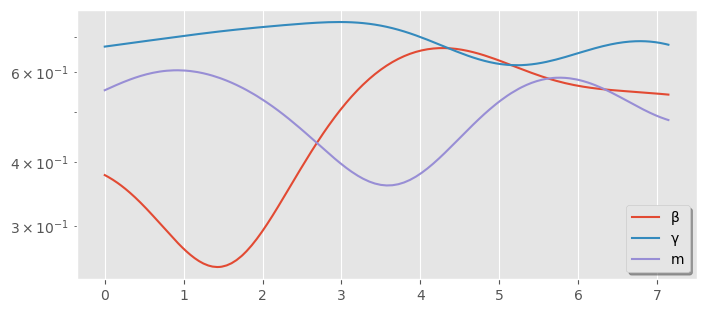

In [40]:
# Plot initial point
plt.figure(figsize=(8,3.5))
plt.plot(Tₑ, α.T)
plt.legend(['β', 'γ', 'm'], shadow=True)
plt.yscale('log')
plt.show()

## Solve a state:

In [41]:
def SIRD(t, z,  α_interp):
    β, γ, m = [aᵦ,aᵧ,aₘ] * α_interp(t)    # Use interpolator and scale parameters
    S, I, R, D = z
    return [β*(n-S)*I, β*(n-S)*I - γ*I - m*I, γ*I, m*I]

In [42]:
sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=[α.interp], t_eval = Tₑ, dense_output=True, vectorized=True, rtol = 1e-6)
print(sol['message'],'There were',sol.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 62 function evaluations.


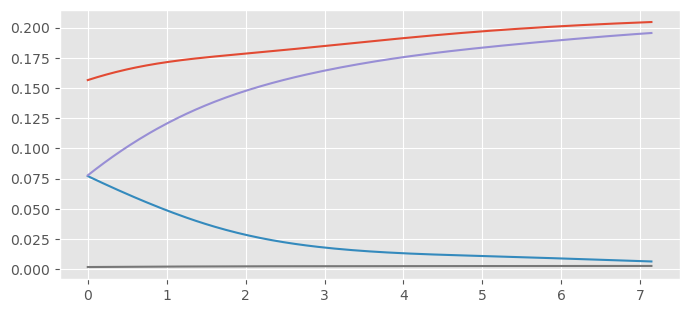

In [43]:
# Plot solution:
plt.figure(figsize=(8,3.5))
#plt.plot(Tₑ,n-sol.y[0].T)
plt.plot(Tₑ,sol.y.T)
#plt.yscale('symlog', linthresh=1e-1)
#plt.xscale('symlog', linthresh=1e-2)
plt.plot();

## Solve its adjoint

The adjoint state can be found by solving the following ODE system:

\begin{align}
    \frac{\dif q_\sigma}{\dif t} &= \hat{\sigma} - \sigma + [a_1 \beta] I (q_\sigma + q_I),
    \\
    \frac{\dif q_I}{\dif t} &= \hat{I} - I - [a_1 \beta] (n-\sigma)(q_\sigma + q_I) + [a_2\gamma] (q_I - q_R) + [a_3 m] (q_I - q_D),
    \\
    \frac{\dif q_R}{\dif t} &= \hat{R} - R,
    \\
    \frac{\dif q_D}{\dif t} &= \hat{D} - D,
\end{align}
with the terminal condition $q(T) = \vartheta\big[\rho(T) - \widehat{\rho}(T)\big]$.

In [44]:
# Interpolator from ODE
ρₜ = sol.sol
ρ = sol.y

In [45]:
dw = simpson((ρ̂ - (simpson((ρ̂), x=Tₑ)/T)[::,np.newaxis])**2, x = Tₑ) ** -1    # Goodness of fit weight

In [46]:
def Adjoint(t, z, α_interp,ρ):
    β, γ, m = [aᵦ,aᵧ,aₘ] * α_interp(t)    # Use scaled interpolator
    S̄, Ī, R̄, D̄ = dw * ρ̄(t)           # Target
    S, I, R, D = dw * ρ(t)           # State
    qₛ, qᵢ, qᵣ, qᵈ = z           # Adjoint
    return [S̄ - S + β*I*(qₛ + qᵢ), Ī - I - β*(n-S)*(qₛ + qᵢ) + γ*(qᵢ - qᵣ) + m * (qᵢ - qᵈ), R̄ - R, D̄ - D]

In [47]:
qₒ = ϑᵀᵉʳ * (ρ[:,-1] - ρ̂ᶠ)
solₛ = solve_ivp(Adjoint, [T,0], qₒ, args=(α.interp,ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False)
q = solₛ.y[:,::-1]
print(solₛ['message'],'There were',solₛ.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 86 function evaluations.


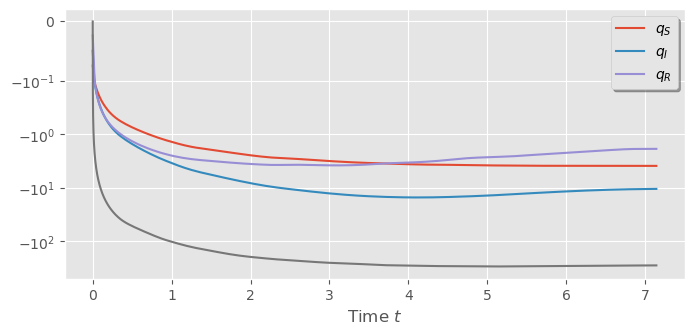

In [48]:
# Plot adjoint curves
plt.figure(figsize=(8,3.5))
plt.plot(Tₑ[::-1],q.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$q_S$', '$q_I$', '$q_R$'], shadow=True)
#plt.yscale('log')
plt.yscale('symlog', linthresh=1e-1)
plt.show()

## Cost and gradient

Let us evaluate the function
\begin{align}
    j(\alpha) = \frac{1}{2} \int\limits_0^T w_1 \big( \sigma(t) - \hat{\sigma}(t) \big)^2 +  w_2 \big( I(t) - \hat{I}(t) \big)^2 + w_3 \big( R(t) - \hat{R}(t) \big)^2 + w_4 \big( D(t) - \hat{D}(t) \big)^2 +  \big( \theta_1 \beta^2(t) + \theta_2 \gamma^2(t) + \theta_3 m^2(t) \big) \,\dif t  + \frac{1}{2} \| \vartheta (\rho(T) - \widehat{\rho}(T)) \|^2_{\R^3}
    .
\end{align}

In [49]:
def Objective(ρ,ρ̂,α, θ,ϑᵀᵉʳ,  scale = 1.0):
    # State + controls
    s  = (dw * simpson((ρ-ρ̂)**2, x=Tₑ)).sum()  +  (ϑᵀᵉʳ * (ρ[:,-1] - ρ̂ᶠ)**2).sum()
    s *= scale
    # Controls
    s +=  (α.Ens * θ.T).sum()
    # Weight
    s *= 0.5
    return s

In [50]:
print('As an example, the objective value for α is {0:.4e}.'.format(  Objective(ρ,ρ̂, α, θ, ϑᵀᵉʳ, scale = (1) ) ))

As an example, the objective value for α is 3.9454e+00.


Now we can compute the derivative of the reduced objective functional [ ! ]:
\begin{align}
    \frac{\partial f}{\partial \beta} &=  a_1 (n-\sigma) I( q_\sigma + q_I )  + \theta_1 \beta
    \\
    \frac{\partial f}{\partial \gamma} &=  a_2 I( q_R - q_I )   + \theta_2 \gamma
    \\
    \frac{\partial f}{\partial m} &=  a_3I (q_D - q_I)    + \theta_3 m
\end{align}

In [51]:
df = asarray([aᵦ * ρ[0]*ρ[1] * (q[1]+q[0]),  aᵧ * ρ[1] * (q[2]-q[1]),  aₘ * ρ[1] * (q[3]-q[1]) ])  + θ * α.data

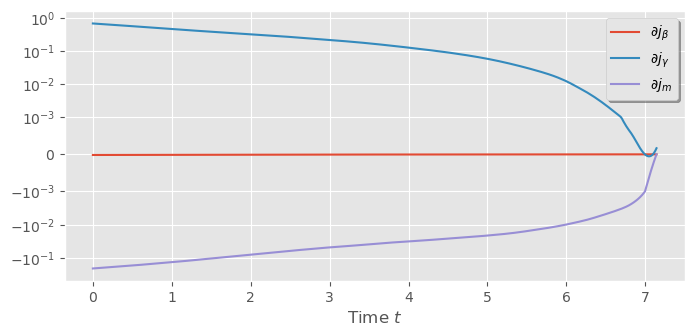

In [52]:
# Plot derivative
plt.figure(figsize=(8,3.5))
plt.plot(Tₑ,df.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$\partial j_β$', '$\partial j_γ$', '$\partial j_m$'], shadow=True)
#plt.yscale('log')
plt.yscale('symlog', linthresh=1e-3)
plt.show()

### Define projection

In [53]:
def proj(α):    return Arg(np.clip(α, 2e-2, upper_b))

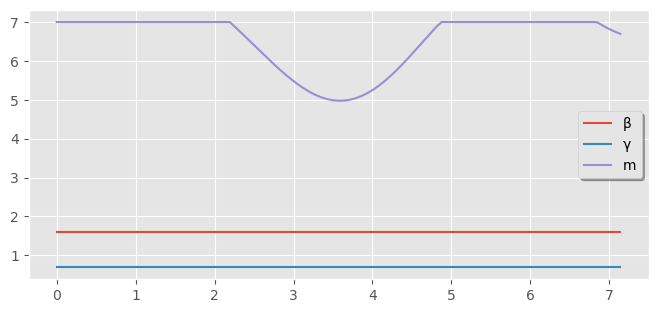

In [54]:
# Test projection
plt.figure(figsize=(8,3.5))
plt.plot(Tₑ, proj( 1.4e+1*(α-0.005) ).data.T)
plt.legend(['β', 'γ', 'm'], shadow=True)
plt.show()

# A few evaluations

Let us evaluate the objective for some curves:

In [55]:
global ρ, q
ρ = np.zeros_like(ρ̂)
q = np.zeros_like(ρ̂)

In [56]:
# Increase tolerance: Quasi-Newton methods are generally more susceptible to numerical errors
# 1e-3 is the default tolerance of the solver, 1e-4 produces fair results and this is replicated in 1e-6
rt = 1e-9
# Scale the population compartments by some quantity; e.g., n^-2 scales by total number of people at time 0
scaling = True
scale = 1 if scaling else 1.0

def obj_eval(α):                  # ** Eval f and f' ** #
    global ρ, q, df
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α.interp,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1, rtol=rt)
    if ρ_sol['success'] != True:    print('Should re-evaluate.')
    ρ  = ρ_sol.y
    f  = Objective(ρ,ρ̂, α, θ, ϑᵀᵉʳ,  scale)
    
    # Create an abstract interpolator for state
    ρₜ = ρ_sol.sol
    
    # Compute adjoint
    qₒ = ϑᵀᵉʳ * (ρ[:,-1] - ρ̂ᶠ)    # Terminal condition
    q_sol = solve_ivp(Adjoint, [T,0], qₒ, args=(α.interp,ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False, rtol=rt)
    q = q_sol.y[:,::-1]

    # Compute derivative
    df = scale * asarray([ aᵦ * ρ[0]*ρ[1] * (q[1]+q[0]),    aᵧ * ρ[1] * (q[2]-q[1]),    aₘ * ρ[1] * (q[3]-q[1]) ])
    df += θ * α.data
    
    return asarray(f), df
def obj_eval_a(α):                # ** Eval just f ** #
    global ρ
    '''
        Evaluate state and return objective
    '''
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α.interp,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1, rtol=rt)
    if ρ_sol['success'] != True:    print('Should re-evaluate.')
    ρ  = ρ_sol.y
    f  = Objective(ρ,ρ̂, α, θ, ϑᵀᵉʳ,  scale)
    
    return asarray(f)
def obj_eval_b(α):                # ** Does not affect global variable ρ ** #
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α.interp,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1, rtol=rt)
    if ρ_sol['success'] != True:    print('Should re-evaluate.')
    ρₐ = ρ_sol.y
    f  = Objective(ρₐ,ρ̂,α, θ, ϑᵀᵉʳ,  scale)

    return asarray(f)
def obj_eval_d(α):                # ** Does not affect global variables ρ, q, df ** #
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α.interp,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1, rtol=rt)
    if ρ_sol['success'] != True:    
        print('Should re-evaluate.')
        plt.plot(ρ_sol.y.T)
        plt.show()
        print(ρ_sol)
    ρᵦ = ρ_sol.y
    f  = Objective(ρᵦ,ρ̂, α, θ, ϑᵀᵉʳ,  scale)
    
    # Create an abstract interpolator for state
    ρₜ = ρ_sol.sol
    
    # Compute adjoint
    qₒ = ϑᵀᵉʳ * (ρᵦ[:,-1] - ρ̂ᶠ)    # Terminal condition
    q_sol = solve_ivp(Adjoint, [T,0], qₒ, args=(α.interp,ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False, rtol=rt)
    qᵦ = q_sol.y[:,::-1]

    # Compute derivative
    dF = scale * asarray([ aᵦ * ρᵦ[0]*ρᵦ[1] * (qᵦ[1]-qᵦ[0]),    aᵧ * ρᵦ[1] * (qᵦ[2]-qᵦ[1]),    aₘ * ρᵦ[1] * (qᵦ[3]-qᵦ[1]) ])
    dF += θ * α.data

    return asarray(f), dF

In [57]:
obj_eval_a(α)

array(3.94545549)

---

In [58]:
Samples = rng(2024).multivariate_normal( 0.0*Tₑ, rbf_kernel(Tₑ[::,np.newaxis], gamma = 0.25), size = (20,3) )
Samples = 1 * (0.5 * (np.transpose(Samples, (0, 2, 1)) - Samples.min())/np.ptp(Samples) + 0.25)

In [59]:
#Samples[:,:,0].max() > 1e-2   # returns false
#(Samples[:,:,1:].sum(2) > 1).any()   # same

In [60]:
Misfit = zeros([20,1])
for i in range(20):
    Misfit[i] = obj_eval_a(Arg(Samples[i].T))

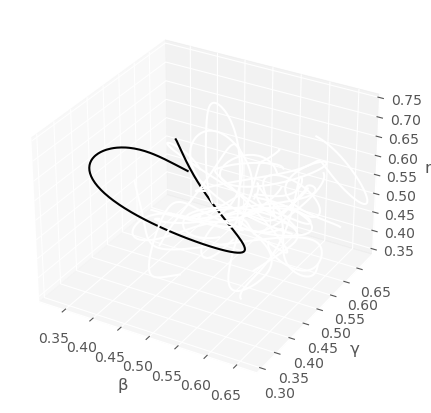

In [61]:
# Coarse sample
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure( figsize=(5, 11) )
ax = fig.add_subplot(111, projection='3d')

# Plot each curve with colors reflecting the Misfit values
for i, curve in enumerate(Samples):
    x = curve[:, 0]  # X coordinates
    y = curve[:, 1]  # Y coordinates
    z = curve[:, 2]  # Z coordinates
    
    # Get the color for the current curve based on the Misfit value
    color = colormaps['bone']( 255* (1 - Misfit[i]/Misfit.max()))
    
    # Plot the curve in 3D with the corresponding color
    ax.plot(x, y, z, c = color)

# Set labels for the axes
ax.set_xlabel('β')
ax.set_ylabel('γ')
ax.set_zlabel('m')
ax.set_xlim([ max(0, Samples[:,:,0].min()), min(1e-2, Samples[:,:,0].max() ) ])
ax.set_xlim([ max(0, Samples[:,:,1].min()), min(1, Samples[:,:,1].max() ) ])
ax.set_zlim([ max(0, Samples[:,:,2].min()), min(1, Samples[:,:,2].max() ) ])

ax.set_facecolor('xkcd:white')
ax.set_box_aspect((1, 1, 0.75))
# Show the plot

plt.show()

In [62]:
print('Smallest objective found in the sample: {0};'.format( Misfit.min()) )

Smallest objective found in the sample: 2.684353507128979;


# Solving the optimisation problem

## Optimisation routine

We will use a gradient-based algorithm for optimising $f$. For any $L > 0$, and $\omega \in [0,1]^2$, define the the operator
$$
    p_L (\omega) := \mathcal{P}_{[0,1]^2}[\omega - L^{-1} \nabla f(\omega) ].
$$

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Nonmonotone Accelerated Proximal Gradient Algorithm</h2>
<ol>
<li>Let $\alpha_0 = \alpha_1 = \omega_1 = \nu_1 \in [0,1]^2$, $\theta_0 = 0$, $\theta_1 = 1$, $\mu \in [0,1)$, $\delta >0$, $\eta > 1$, $c_1 = j(\alpha_1)$, $\lambda_1 = 1$.</li>

    
<li>For $k \in \{1,\ldots\}$, do
<ol>
<li>Set 
    \begin{align*}
        \nu_{k} &= \alpha_k + \frac{\theta_{k-1}}{\theta_k} (\omega_k - \alpha_k) + \frac{\theta_{k-1} -1 }{\theta_k} (\alpha_k - \alpha_{k-1}) 
    \\
        s_{k} &= \nu_k - \nu_{k-1}
        \qquad
        r_k = \nabla j(\nu_k) - \nabla j(\nu_{k-1})
    \\
        L_k &= \mathcal{P}_{[10^{-20},10^{20}]} \left( \frac{s_k^\top r_k}{s_k^\top s_k} \right)  
    \end{align*}
    
    
<li>Find the smallest $i_k \in \mathbb{N}$ such that
    \begin{align*}
        L &= \eta^{i_k} L_k
        \\
        \omega_{k+1} &= \mathcal{P} (\nu_k - L^{-1} \nabla j(\nu_k) ) = p_L(\nu_{k})
        \\
    j(\omega_{k+1}) &\leq \max\{c_k,j(\nu_k)\} - \delta \| \omega_{k+1} - \nu_k \|^2
    \end{align*}

    
<li> If $j(\omega_{k+1}) \leq c_k - \delta \| \omega_{k+1} - \nu_k \|^2$, then:
    <ol> 
        <li> $\alpha_{k+1} = \omega_{k+1}$
    </ol>
<li>Else:
    <ol>
        <li> Set 
    \begin{align*}
        s_{k} &= \alpha_k - \nu_{k-1}
        \qquad
        r_k = \nabla j(\alpha_k) - \nabla j(\nu_{k-1})
    \\
        L_k &= \mathcal{P}_{[10^{-20},10^{20}]} \left( \frac{s_k^\top r_k}{s_k^\top s_k} \right)  
    \end{align*}
    <li>Find the smallest $i_k \in \mathbb{N}$ such that
        \begin{align*}
            L &= \eta^{i_k} L_k
            \\
            \xi_{k+1} &= \mathcal{P} (\alpha_k - L^{-1} \nabla j(\alpha_k) ) = p_L(\alpha_{k})
            \\
        j(\xi_{k+1}) &\leq c_k - \delta \| \xi_{k+1} - \alpha_k \|^2
    \end{align*}
        <li> Assign
            \begin{align*}
                \alpha_{k+1} = \begin{cases}
                                    \omega_{k+1} &\text{if }  j(\omega_{k+1}) \leq j(\xi_{k+1}),
                                    \\
                                    \xi_{k+1} &\text{otherwise}.
                               \end{cases}
            \end{align*}
    </ol>
<li> Update $\theta_{k+1} = \frac{1}{2} \Big[ 1 + \sqrt{ 1 + 4 \theta_k^2 } \Big]$
<li> Update $\lambda_{k+1} = \mu \lambda_k + 1$
<li> Update $c_{k+1} = \lambda_{k+1}^{-1} \big[ \mu \lambda_k c_k + j(\alpha_{k+1}) \big]$

</ol>
</div>

## Algorithm

In [63]:
scale

1

In [64]:
def box_scale(x,y):
    '''
        Return minimum value of scalar s > 0  such that x + sy ∈ [0,1] for x ∈ [0,1]
    '''
    a = np.divide(x, y, where=(y>0))[y>0]
    b = np.divide((x-1), y, where=(y<0))[y<0]
    if len(a) > 0:
        if len(b) > 0:
            return min( a.min(), b.min() )
        else:
            return a.min()
    else:
        return b.min()

In [65]:
def nmAPG(α, iters, save_iter = False, critical = 1, εₐ = 1e-9, εᵦ = 5e-13, print_tests = False):
    '''
        Create structures to store information from iterates
    '''
    every_iter = {
        'it':[], 'obj':[], 'time':[], 
        'norms':{'ℓ_1': [], 'ℓ_2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'time':[], '|df|_2':[], '|df|_max':[]}
    best = {'obj': 1e+10, 'α': None, 'df': None}
    
    '''
        Iterates
    '''
    print('     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  ')
    print( '{:–^62}'.format('') )
    
    ''' 
        Initialisation
    '''
    # Iterate, interpolation, proximal points
    αₒ = α.copy();    νₒ = α.copy();    ωₒ = α.copy()

    θₖ = 1.0;    θₒ = 0.0      # Inertia parameter (not to be confused with θ)
    μ = 0.01 #0.001    # Degree of nonmonotonicity
    η = 2.5 #2.5     # Scaling for backtracking
    δ = .5e-1         # Sufficient decrease
    I = 10            # Number of iterations for line search
    
    # First objective evaluation
    # Compute state and adjoint for α
    jα, djα = obj_eval(α)
    djνₒ = djα.copy()
    # Initial evaluation
    c = jα;    jαₒ = 0.0
    λ = 1.0
    
    print('* {0:6.0f} |  {1:.1e} |  {2:7.2f}  | {3:6.3e}   |   {4:6.3e}  '.format(0, jα, 0.0, norm(djα.ravel())/(3*T**0.5), norm(djα.ravel(),np.inf) ))

    # Store info for initial point
    if save_iter:
        every_iter['it'].append( 0 )
        every_iter['obj'].append( jα )
        every_iter['time'].append( 0.0 )
        # Store norms of gradient
        every_iter['norms']['ℓ_2'].append( norm(djα.ravel())/(3*T**0.5) )
        every_iter['norms']['ℓ_1'].append( (1.0/(3*T)) * norm(djα.ravel(),1) )
        every_iter['norms']['max'].append( norm(djα.ravel(), np.inf) )
        every_iter['norms']['min'].append( abs(djα.ravel()).min() )
        # Store best point
        if jα < best['obj']:
            best['obj'] = jα
            best['α']  =   α.copy()
            best['df'] = djα.copy()
    
    timed = 0.0
    for k in range(1,iters+1):
        it_time = time.time()
        
        # ------------ Step 1 ------------ #
        # Compute 
        ν = α + (θₒ/θₖ) * (ωₒ - α) + ((θₒ - 1.0)/θₖ) * (α - αₒ)
        if print_tests:            print( (1,k), ν.En) 
        # Project points just in case and evaluate objective and gradient
        ν = proj(ν)
        jν, djν = obj_eval(ν)
        if print_tests:            print( (1,k), jν )
        # Barzilai–Borwein
        s = ν - νₒ;             r = djν - djνₒ
        #print(k, s.dot(r)/s.dot(s), r.dot(r)/s.dot(r))
        L = 1 if k == 1 else s.dot(r)/s.dot(s)
        L = min( max(1e-20, L), 1e20)
        # Go one step ahead: if ν - b * djν goes too far, backtracking will waste time!
        bₜ = box_scale(ν.data,djν)
        L = L if bₜ < 1e-20 else max(L, 1.0/bₜ)
        
        # ------------ Step 2 ------------ #
        for i in range(I):
            # Temporary approximation of Lipschitz constant
            Lₓ = η**i * L;        b = 1.0/Lₓ
            # Gradient and proximal step
            ω = proj(ν - b * djν)
            # Evaluate objective at ω
            jω = obj_eval_a(ω)
            # Validate step
            if print_tests:            print( (2,k,i), ω.En,jω) 
            if (jω + δ * norm((ν - ω).data.ravel())**2) <= max(jν,c):
                break
            
        # ------------ Step 3 ------------ #
        if (jω + δ * norm((ν - ω).data.ravel())**2) <= c:
            αₒ = α.copy()
            α  = ω.copy()
        else:
            # Barzilai–Borwein
            s = α - νₒ;             r = djα - djνₒ
            L = s.dot(r)/s.dot(s)
            L = min( max(1e-20, L), 1e20)
            #print(s.dot(s), L)
            
            ''' Line search for interpolation '''
            # Go one step ahead: if α - b * djα goes too far, backtracking will waste time!
            # For any component without a zero gradient, the value of b has to satisfy 
            #    b ∈ [(α-1)/djα, α/djα] if djα > 0   and  [α/djα, (α-1)/djα]  if djα < 0
            # Thus the largest b satisfying these conditions is the minimum upper bound of each interval
            #
            bₜ = box_scale(α.data,djα)
            # Now we can either fix I or change L:
            L = L if bₜ < 1e-20 else max(L, 1.0/bₜ)
            
            for i in range(I):
                # Temporary approximation of Lipschitz constant
                Lₓ = η**i * L;        b = 1.0/Lₓ
                # Gradient and proximal step
                ξ  = proj(α - b * djα)
                # Evaluate objective at ω
                jξ = obj_eval_a(ξ)
                # Validate step
                if print_tests:            print( (3,k,i), ω,jω) 
                if (jξ + δ * norm((ξ - α).data.ravel())**2) <= c:
                    break
                    
            # Asign next step
            αₒ = α.copy()
            α = ω.copy() if (jω <= jξ) else ξ.copy()
            if print_tests:            print( (4,k), α.En,jα)
            
        # ------------ Step 4 ------------ #
        # Update objective and previous steps
        jαₒ = jα
        jα, djα = obj_eval(α)
        ωₒ = ω.copy()
        νₒ = ν.copy();        djνₒ = djν.copy()
        
        # Update inertia weights
        θₒ = θₖ
        θₖ = 0.5 * (1.0 + (1.0 + 4.0 * θₖ**2)**0.5)
        if print_tests:            print( (4,k),θₖ,θₒ)
        # Update exponential convex combination of objectives (19 in Li & Lin 2015)
        c = ((μ * λ * c) + jα)/ ((μ * λ) + 1)
        λ = (μ * λ) + 1
        if print_tests:            print( (4,k),c,λ)
        
        
        
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time        
        
        if save_iter:
            every_iter['it'].append( k )
            every_iter['obj'].append( jα )
            every_iter['time'].append( timed )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(djα.ravel())/(3*T**0.5) )
            every_iter['norms']['ℓ_1'].append( (1.0/(3*T)) * norm(djα.ravel(),1) )
            every_iter['norms']['max'].append( norm(djα.ravel(), np.inf) )
            every_iter['norms']['min'].append( abs(djα.ravel()).min() )
            # Update point if needed
            if jα < best['obj']:
                best['obj'] = jα
                best['α']  =   α.copy()
                best['df'] = djα.copy()
        
        if k % critical == 0:
            every_critical['it'].append( k )
            every_critical['obj'].append( jα )
            every_critical['time'].append( timed )
            every_critical['|df|_2'].append( norm(djα.ravel())/(3*T**0.5) )
            every_critical['|df|_max'].append( norm(djα.ravel(), np.inf) )
            
            print('* {0:6.0f} |  {1:.1e} |  {2:7.2f}  | {3:6.3e}   |   {4:6.3e}  '.format(k, jα, timed,
                                                                        norm(djα.ravel())/(3*T**0.5), norm(djα.ravel(), np.inf) ))
        
        if abs(jα - jαₒ) < εᵦ and k > 10:
            print('|j-jₖ| < {0:1.0e}'.format(εᵦ))
            #print(α)
            break
        
        if norm(α - αₒ, ord='fro')/(3*T**0.5) < εₐ:
            print('‖αₖ - p‖ < {0:1.0e}'.format(εₐ))
            #print(α)
            break
        
    print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    # Due to nonmonoticity, last iterate is not necessarily the best candidate
    idx = np.argmin(every_iter['obj'])
    α = best['α']
    jα = obj_eval_a(α)
    print(α.En, jα)
    
    return α, ρ, every_critical, every_iter, best

In [66]:
#ϑᵀᵉʳ = 1e+1 #np.asarray([1e-4,1e-4,5e+2])
#θ = 1e-8 * np.ones(3)[::,np.newaxis] #np.asarray([1e-6,1e-8,1e-9])[::,np.newaxis]

In [67]:
from sklearn.metrics import r2_score

In [68]:
ω = np.ones_like(α.data)
ω[0] *= 0.66805134  # 0.68020204  
ω[1] *= 0.17223737  # 0.17558764
ω[2] *= 0.50569583 # 1.48806091
ω = Arg(ω)

In [69]:
ᾱ, ρ, every_critical, every_iter, best = nmAPG(ω, 2000, save_iter = True, critical = 10, εₐ = 1e-13, εᵦ = 1e-13, print_tests = False);

     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
*      0 |  1.6e-01 |     0.00  | 3.231e-01   |   3.770e-01  
*     10 |  1.3e-01 |     1.57  | 1.865e-01   |   1.639e-01  
*     20 |  1.1e-01 |     3.22  | 4.659e-02   |   4.453e-02  
*     30 |  1.0e-01 |     5.05  | 4.376e-02   |   3.594e-02  
*     40 |  1.0e-01 |     7.16  | 5.916e-02   |   4.682e-02  
*     50 |  1.0e-01 |     9.30  | 1.870e-02   |   2.448e-02  
*     60 |  9.9e-02 |    11.55  | 2.891e-02   |   2.654e-02  
*     70 |  9.9e-02 |    13.78  | 2.923e-02   |   2.540e-02  
*     80 |  9.8e-02 |    16.24  | 2.928e-02   |   2.620e-02  
*     90 |  9.8e-02 |    18.45  | 1.479e-02   |   2.456e-02  
*    100 |  9.7e-02 |    20.86  | 1.145e-02   |   2.386e-02  
*    110 |  9.7e-02 |    23.18  | 2.952e-02   |   2.844e-02  
*    120 |  9.7e-02 |    25.67  | 2.278e-02   |   2.424e-02  
*    130 |  9.6e-02 |    28.36  | 1.156e-02   |   2.365e-02  
*    14

*   1310 |  7.9e-01 |   349.15  | 9.634e-02   |   8.507e-02  
*   1320 |  7.8e-01 |   351.33  | 3.974e-02   |   5.958e-02  
*   1330 |  7.8e-01 |   353.67  | 7.451e-02   |   6.243e-02  
*   1340 |  7.7e-01 |   356.53  | 1.002e-01   |   8.214e-02  
*   1350 |  7.7e-01 |   358.90  | 9.254e-02   |   7.638e-02  
*   1360 |  7.7e-01 |   361.19  | 1.026e-01   |   8.429e-02  
*   1370 |  7.6e-01 |   363.62  | 6.899e-02   |   5.510e-02  
*   1380 |  7.6e-01 |   365.97  | 1.558e-01   |   1.279e-01  
*   1390 |  7.6e-01 |   368.09  | 5.441e-02   |   5.065e-02  
*   1400 |  7.5e-01 |   370.18  | 9.267e-02   |   7.581e-02  
*   1410 |  7.5e-01 |   372.61  | 1.118e-01   |   9.381e-02  
*   1420 |  7.5e-01 |   374.82  | 6.075e-02   |   4.809e-02  
*   1430 |  7.4e-01 |   377.13  | 1.419e-01   |   1.180e-01  
*   1440 |  7.4e-01 |   379.54  | 7.108e-02   |   5.866e-02  
*   1450 |  7.3e-01 |   381.70  | 4.283e-02   |   6.011e-02  
*   1460 |  7.2e-01 |   384.04  | 5.539e-02   |   4.363e-02  
*   1470

Goodness of fit:

In [70]:
print(1 - (simpson((ρ-ρ̂)**2, x=Tₑ) * dw), '  ', r2_score(ρ̂,ρ, sample_weight=dw))

[0.94391907 0.91494789 0.96998427 0.98754638]    0.9776579997633472


---

In [71]:
simpson((ρ-ρ̂)**2, x=Tₑ).sum(),  ϑᵀᵉʳ * ((ρ[:,-1] - ρ̂ᶠ)**2), (ᾱ.Ens)**0.5

(0.05039387073816843,
 array([2.33906876e-03, 1.14789515e-03, 1.99659601e-04, 1.24766577e-07]),
 array([1.77804834, 0.77470771, 1.68695665]))

In [72]:
((ρ[:,-1] - ρ̂ᶠ))

array([0.15294014, 0.10713987, 0.04468329, 0.00111699])

---

In [73]:
#CMap = get_cmap('Wistia')
CMap = colormaps['BuGn']
colours_nmAPG = CMap(150)

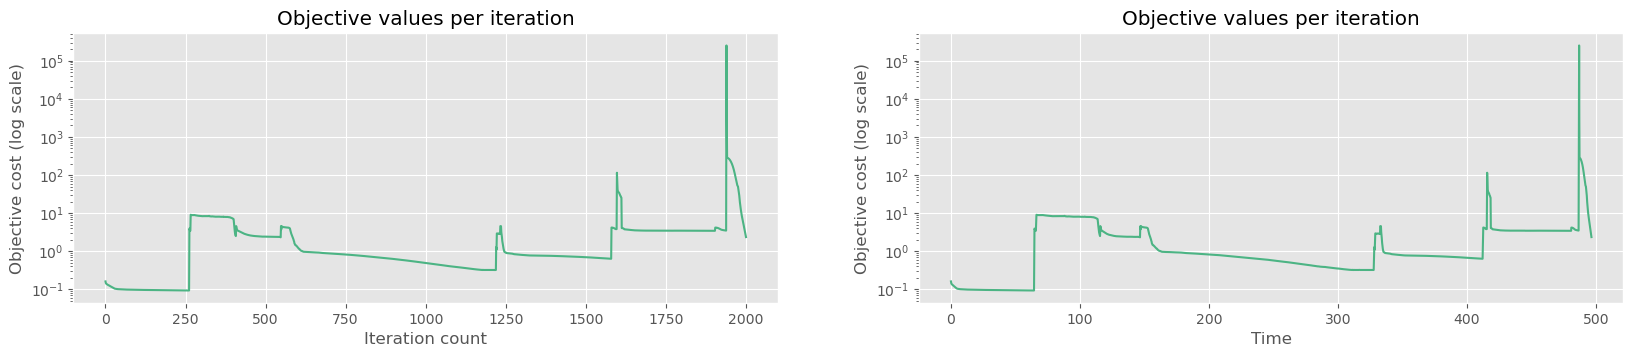

In [74]:
# Visualise evolution of objective values
plt.figure(figsize = (20,3.5))

plt.subplot(1, 2, 1)
#plt.plot(every_iter['obj'] - min(every_iter['obj']), c = colours_nmAPG)
plt.plot(every_iter['obj'] , c = colours_nmAPG)
plt.yscale('log');    
plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')
plt.subplot(1, 2, 2)
plt.plot(every_iter['time'],every_iter['obj'] , c = colours_nmAPG)
#plt.plot(every_iter['time'],every_iter['obj'] - min(every_iter['obj']), c = colours_nmAPG)
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Time');    plt.ylabel('Objective cost (log scale)')

#plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

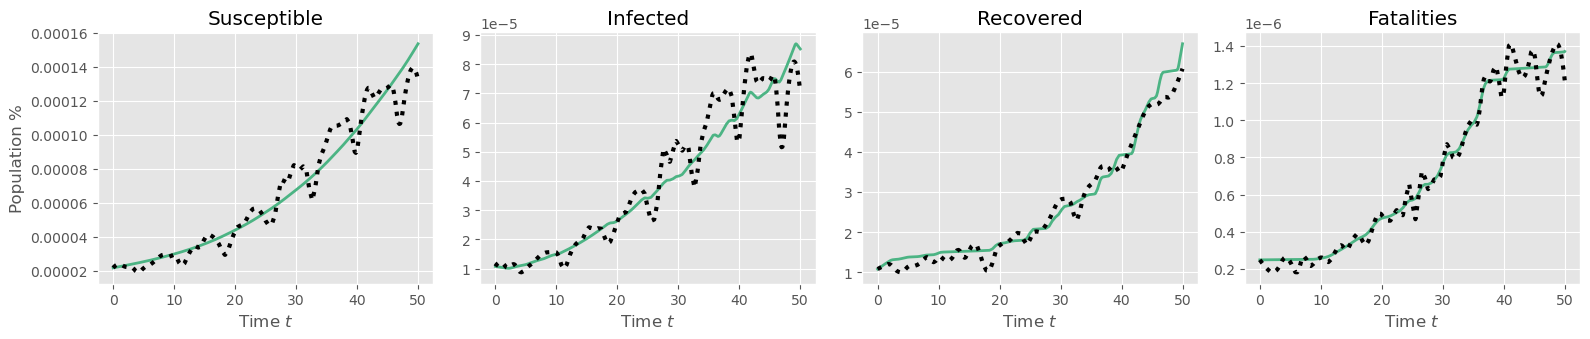

In [75]:
# Plot state 
fig, ax = plt.subplots(1, 4, figsize=(16, 3.5))

# Add state
ax[0].plot(Tₑ*7, ρ[0]/n, '-', c=colours_nmAPG, linewidth=2)
ax[1].plot(Tₑ*7, ρ[1]/n, '-', c=colours_nmAPG, linewidth=2)
ax[2].plot(Tₑ*7, ρ[2]/n, '-', c=colours_nmAPG, linewidth=2)
ax[3].plot(Tₑ*7, ρ[3]/n, '-', c=colours_nmAPG, linewidth=2)
    
# Add target
ax[0].plot(Tₑ*7, ρ̂[0]/n, ':', c='black', linewidth=3)
ax[1].plot(Tₑ*7, ρ̂[1]/n, ':', c='black', linewidth=3)
ax[2].plot(Tₑ*7, ρ̂[2]/n, ':', c='black', linewidth=3)
ax[3].plot(Tₑ*7, ρ̂[3]/n, ':', c='black', linewidth=3)

ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')
ax[3].set_xlabel(r'Time $t$');    ax[3].set_title(r'Fatalities')

ax[0].set_ylabel('Population %')

#ax[0].set_yscale('log');    ax[1].set_yscale('log');    ax[2].set_yscale('log')

#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
#plt.savefig('Outputs/Regularisation – States – FISTA.pdf', bbox_inches='tight', pad_inches=0)

In [76]:
obj_eval(ᾱ);

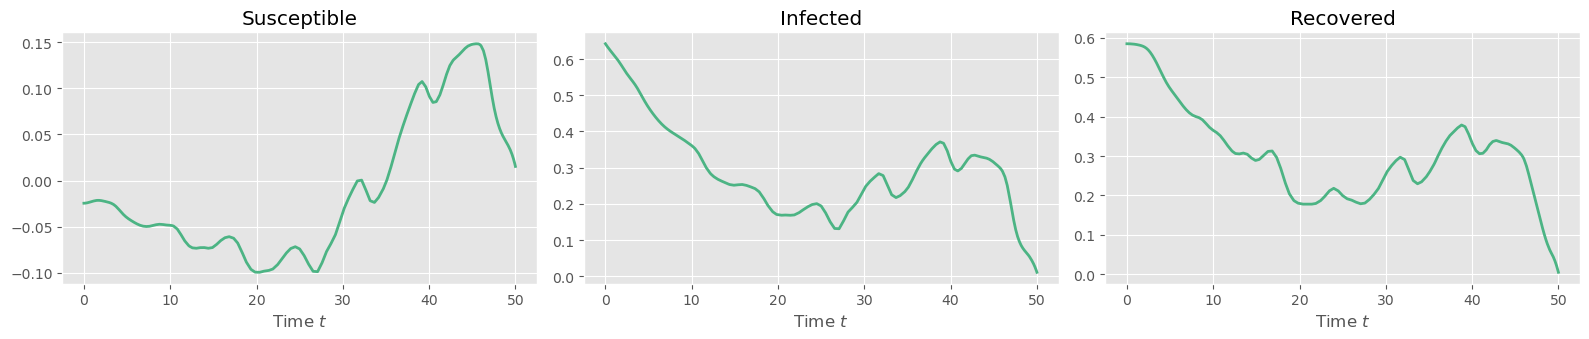

In [77]:
# Plot adjoint
fig, ax = plt.subplots(1, 3, figsize=(16, 3.5))

# Add state
ax[0].plot(Tₑ*7, q[0], '-', c=colours_nmAPG, linewidth=2)
ax[1].plot(Tₑ*7, q[1], '-', c=colours_nmAPG, linewidth=2)
ax[2].plot(Tₑ*7, q[2], '-', c=colours_nmAPG, linewidth=2)
    

ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')



#ax[0].set_yscale('log');    ax[1].set_yscale('log');    ax[2].set_yscale('log')

#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
#plt.savefig('Outputs/Regularisation – States – FISTA.pdf', bbox_inches='tight', pad_inches=0)

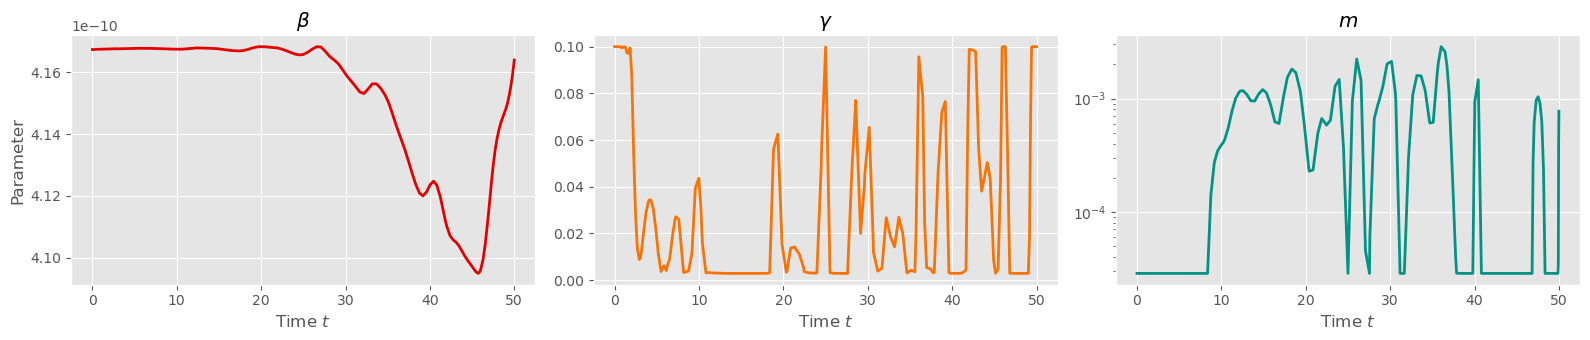

In [78]:
# Plot control 
fig, ax = plt.subplots(1, 3, figsize=(16, 3.5))

# Add state
ax[0].plot(Tₑ*7, ᾱ.data[0]*aᵦ/(time_scale*ppl_scales), '-', c='xkcd:red', linewidth=2)   #scale to original units
ax[1].plot(Tₑ*7, ᾱ.data[1]*aᵧ/time_scale, '-', c='xkcd:orange', linewidth=2)
ax[2].plot(Tₑ*7, ᾱ.data[2]*aₘ/time_scale, '-', c='xkcd:teal', linewidth=2)

ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'$\beta$')
ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'$\gamma$')
ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'$m$')

ax[0].set_ylabel('Parameter')

#ax[0].set_yscale('log');    
#ax[1].set_yscale('log');    
ax[2].set_yscale('log')

#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
#plt.savefig('Outputs/Regularisation – States – FISTA.pdf', bbox_inches='tight', pad_inches=0)

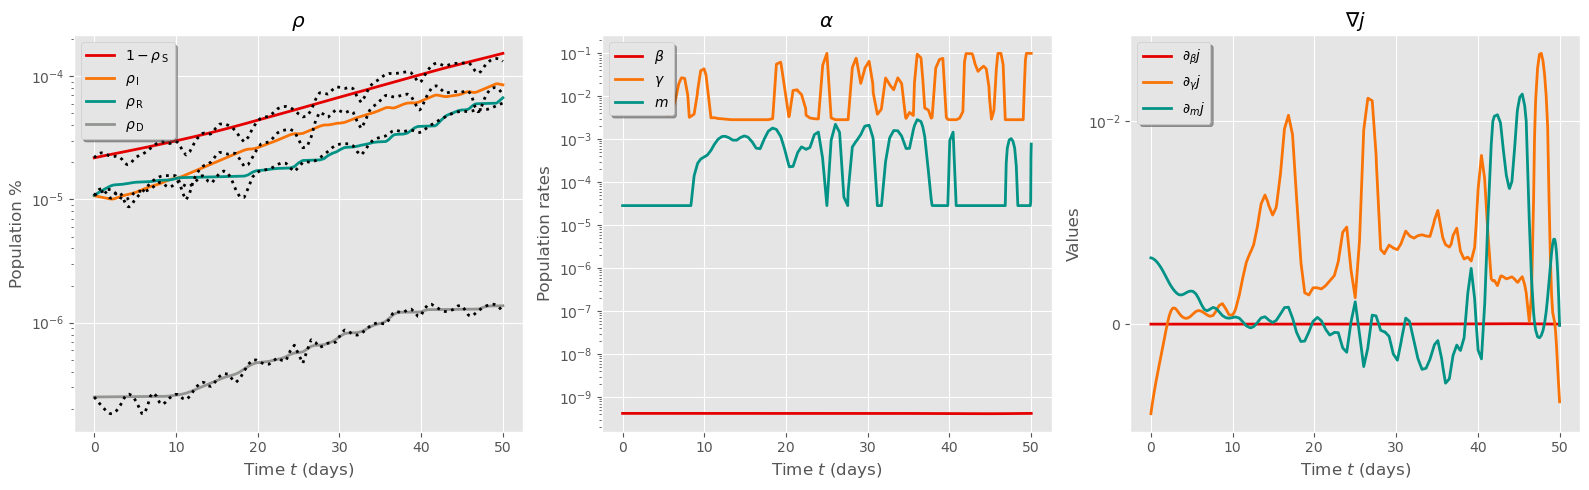

In [79]:
# Plot state 
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
colors = ['xkcd:red','xkcd:orange','xkcd:teal','xkcd:gray']

# Add state
ax[0].plot(Tₑ*7, ρ[0].T * ppl_scales / SIRD_data[0].sum(), '-', linewidth=2)
ax[0].plot(Tₑ*7, ρ[1:].T* ppl_scales / SIRD_data[0].sum(), '-', linewidth=2)
for i, line in enumerate(ax[0].get_lines()):    line.set_color(colors[i])
ax[0].legend(['$1-ρ_{\,\mathsf{S}}$', '$ρ_{\,\mathsf{I}}$', '$ρ_{\,\mathsf{R}}$', '$ρ_{\,\mathsf{D}}$'], shadow=True, loc='upper left')

ax[0].plot(Tₑ*7, ρ̂[0].T * ppl_scales/SIRD_data[0].sum(), ':', c='black', linewidth=2)
ax[0].plot(Tₑ*7, ρ̂[1:].T* ppl_scales/SIRD_data[0].sum(), ':', c='black', linewidth=2)

ax[1].plot(Tₑ*7, ᾱ.data[0]*aᵦ/(time_scale*ppl_scales), '-', c='xkcd:red', linewidth=2)   #scale to original units
ax[1].plot(Tₑ*7, ᾱ.data[1]*aᵧ/time_scale, '-', c='xkcd:orange', linewidth=2)
ax[1].plot(Tₑ*7, ᾱ.data[2]*aₘ/time_scale, '-', c='xkcd:teal', linewidth=2)
ax[1].legend(['$β$', '$γ$', '$m$'], shadow=True, loc='upper left')

#ax[2].plot(Tₑ*7, best['df'][0] * ppl_scales * time_scale / aᵦ, '-', c='xkcd:red', linewidth=2)
ax[2].plot(Tₑ*7, best['df'][0], '-', c='xkcd:red', linewidth=2)
#ax[2].plot(Tₑ*7, best['df'][1] * time_scale/aᵧ, '-', c='xkcd:orange', linewidth=2)
ax[2].plot(Tₑ*7, best['df'][1] , '-', c='xkcd:orange', linewidth=2)
#ax[2].plot(Tₑ*7, best['df'][2] * time_scale/aₘ, '-', c='xkcd:teal', linewidth=2)
ax[2].plot(Tₑ*7, best['df'][2] , '-', c='xkcd:teal', linewidth=2)
ax[2].legend(['$\partial_β j$', '$\partial_γ j$', '$\partial_m j$'], shadow=True, loc='upper left')


ax[0].set_xlabel(r'Time $t$ (days)');    ax[0].set_title(r'$\rho$')
ax[1].set_xlabel(r'Time $t$ (days)');    ax[1].set_title(r'$\alpha$')
ax[2].set_xlabel(r'Time $t$ (days)');    ax[2].set_title(r'$\nabla j$')

ax[0].set_ylabel('Population %')
ax[1].set_ylabel('Population rates')
ax[2].set_ylabel('Values')

ax[0].set_yscale('log')#, linthresh=1e-2)
ax[1].set_yscale('log')
#ax[1].set_ylim([1e-8, 30*ᾱ.data[2].max()])

#ax[0].set_yscale('log');    ax[1].set_yscale('log');    
ax[2].set_yscale('symlog', linthresh=1e-2)

#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
#plt.savefig('Outputs/DD – Panels – RPQN - H.pdf', bbox_inches='tight', pad_inches=0)

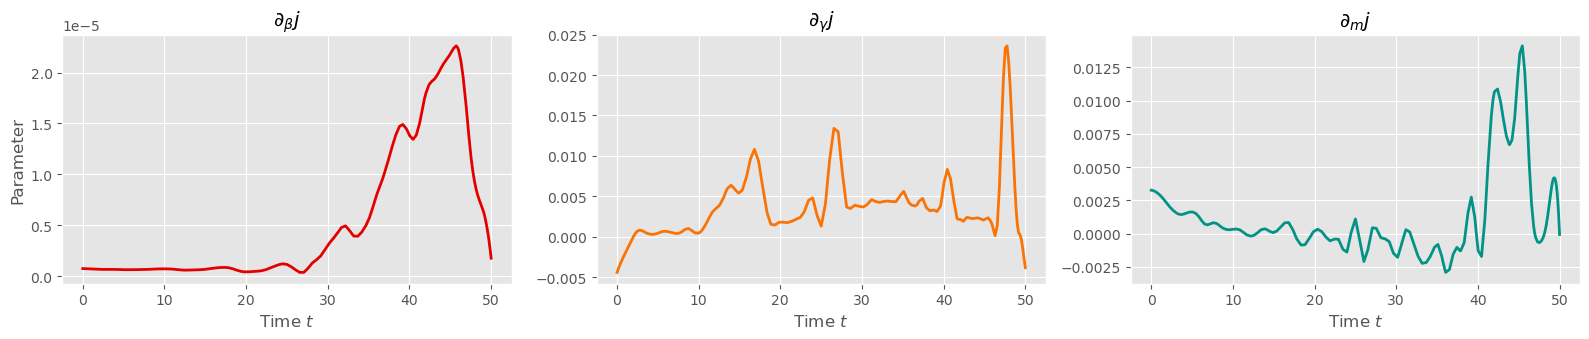

In [80]:
# Plot derivative 
fig, ax = plt.subplots(1, 3, figsize=(16, 3.5))

# Add state
ax[0].plot(Tₑ*7, best['df'][0], '-', c='xkcd:red', linewidth=2)
ax[1].plot(Tₑ*7, best['df'][1], '-', c='xkcd:orange', linewidth=2)
ax[2].plot(Tₑ*7, best['df'][2], '-', c='xkcd:teal', linewidth=2)

ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'$\partial_\beta j$')
ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'$\partial_\gamma j$')
ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'$\partial_m j$')

ax[0].set_ylabel('Parameter')

#ax[0].set_yscale('log');    ax[1].set_yscale('log');    ax[2].set_yscale('log')

#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
#plt.savefig('Outputs/Regularisation – States – FISTA.pdf', bbox_inches='tight', pad_inches=0)

In [81]:
(aᵧ * ᾱ.data[1] + aₘ * ᾱ.data[2]).max() /(time_scale * ppl_scales)

4.403068389731914e-06

---

### Store

In [82]:
every_iter['obj'] = asarray(every_iter['obj'])
#df_every = pd.DataFrame.from_dict(every_iter)
df_every = pd.concat([
                pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
display(df_every.tail())
#
df_every.to_pickle('Outputs/DD – nmAPG - Every - NH - BD - SIRD.pkl') # To read back use pd.read_pickle(file_name)

,it,obj,time,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
1996,1996,3.587726,495.695521,21.420878,6.200955,8.612875,0.000012
1997,1997,3.265313,495.874050,19.042753,5.492387,7.708134,0.000011
1998,1998,2.953942,496.051743,16.952610,4.861456,6.883318,0.000010
1999,1999,2.652298,496.227238,15.076875,4.297426,6.130373,0.000008
2000,2000,2.357873,496.437105,13.334940,3.791219,5.441653,0.000008


In [83]:
# Store info from iterate with smallest objective
ArgMin_nmAPG = df_every.idxmin()['obj']
#Out_θ = 
df_every.loc[[ArgMin_nmAPG]].rename(index={ArgMin_nmAPG:θ}).copy()

,it,obj,time,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
"[[1e-09], [1e-09], [1e-09]]",261,0.093645,64.390574,0.05702,0.011833,0.023613,3.709812e-07


---

In [84]:
np.savez_compressed('Outputs/DD – nmAPG – Best - NH - BD - SIRD', best = best)

In [63]:
#np.load('Outputs/DD – nmAPG – Best.npz', allow_pickle=True)['best']

---